In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics

In [2]:
512**2

262144

In [3]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config = {
    'domain': {
        'minExtent': -L,
        'maxExtent': L,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': nx
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : u_mag * 10
    },
    'shifting':{
        'scheme': 'deltaSPH',
        'threshold': 0.05,
        'maxIterations': 1,
        'freeSurface': False
    },
    'timestep':{
        'dt':0.001,
        'active':True,
        'minDt':1e-6,
    },
    'sps':{
        'active': True
    },
    'noise':{
    #     'n': nx,
        'baseFrequency': 1,
    #     'dim': 2,
        'octaves': 1,
    #     'persistence': 0.5,
    #     'lacunarity': 2,
    #     'seed': 23467586,
    #     'tileable': True,
    #     'kind': 'simplex',
    },
    'diffusion':{
        'velocityScheme': 'deltaSPH_inviscid',
        'alpha': 0.010793905705213547
    },
    'plot':{
        # 'mosaic': '''A''',
    #     'figSize': (6,5.5),
        'plots': {'A': {'val': 'index', 'cbar': True, 'cmap': 'twilight', 'scale': 'lin', 'size': 1, 'gridVis' : False, 'title': 'Fluid Index'}},
    #     'export': True,
        'updateInterval': 32,
    #     'namingScheme': 'timestep',
    #     'exportPath': 'output',
    #     'gif': True,
        'fps': 1000,
    },
    'export':{
        'active': False,
    #     'path': 'export',
    #     'namingScheme': 'timestep',
    #     'interval': 1,
    },
    'boundary':{
        'active':False
    }
    # 'simulation':{'timestamp': datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

if config['diffusion']['velocityScheme'] == 'deltaSPH_inviscid':
    nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']   / (2 * (config['domain']['dim'] + 2)) * 5/4
    Re = u_mag * (2 * L) / config['diffusion']['nu_sph']

    target_nu = u_mag * (2 * L) / targetRe
    alpha = target_nu / (config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4) #/ config['kernel']['kernelScale']
    config['diffusion']['alpha'] = alpha
    # print(alpha)
    if alpha < 0.01:
        print(rf'$\alpha = {alpha}$ is very low, consider increasing the value (should be > 0.01)')
elif config['diffusion']['velocityScheme'] == 'deltaSPH_viscid':
    nu_sph = config['diffusion']['nu']
    Re = u_mag * (2 * L) / config['diffusion']['nu']
    target_nu = u_mag * (2 * L) / targetRe
    config['diffusion']['nu'] = target_nu


config['diffusion']['nu_sph'] = computeViscosityParameter(None, config)# * config['kernel']['kernelScale']
config['diffusion']['Re'] = u_mag * (2 * L) / config['diffusion']['nu_sph']

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$')

# display(config)

Re = 1999.9998779296875, $\nu_{sph} = 0.0020000000949949026$


In [4]:
# computeTimestep(config)


In [5]:
import warnings
targetRe = 3000


# nu_sph = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support']  / (2 * (config['domain']['dim'] + 2)) * 5/4
# nu_sph = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu_sph


In [6]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
TGV_override = False

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
# plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = [], randomizeParticles=True)

priorState = None

if TGV_override:
    k = 1 * np.pi
    particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
    particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# omega = 4

# k = np.pi

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
particleState['velocities'] = particleState['velocities'] / u_max * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

targetEK = 3000
ratio = np.sqrt(targetEK / Ek0.detach().sum().cpu().item())
# print(f'ratio: {ratio}')
particleState['velocities'] = particleState['velocities'] * ratio

initialVelocities = particleState['velocities'].clone()


particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

perennialState = {
    'fluid': copy.deepcopy(particleState),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}
# del particleState['neighborhood']


In [7]:
config['noise']

{'baseFrequency': 1,
 'octaves': 1,
 'n': 128,
 'dim': 2,
 'persistence': 0.5,
 'lacunarity': 2,
 'seed': 7139959,
 'tileable': True,
 'kind': 'simplex'}

In [8]:
# x = particleState['positions'].clone()

# periodic = config['domain']['periodicity']
# minDomain = config['domain']['minExtent']
# maxDomain = config['domain']['maxExtent']
# periodicity = torch.tensor([False] * x.shape[1], dtype = torch.bool).to(x.device)
# if isinstance(periodic, torch.Tensor):
#     periodicity = periodic
# if isinstance(periodic, bool):
#     periodicity = torch.tensor([periodic] * x.shape[1], dtype = torch.bool).to(x.device)

# mod_positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

In [9]:
# lin_x = (mod_positions[:,0] - minDomain[0]) / (maxDomain[0] - minDomain[0])
# lin_y = (mod_positions[:,1] - minDomain[1]) / (maxDomain[1] - minDomain[1])

# gridDim = nx // 2
# linearIndex = (torch.round(lin_x * gridDim) + torch.round(lin_y * gridDim) * gridDim).to(torch.int32)
# sortedIndices = torch.argsort(linearIndex)
# linearIndex[sortedIndices]

E_k0 = 3000, E_k = 3000, rel. diff = 0.00%, Re = nan


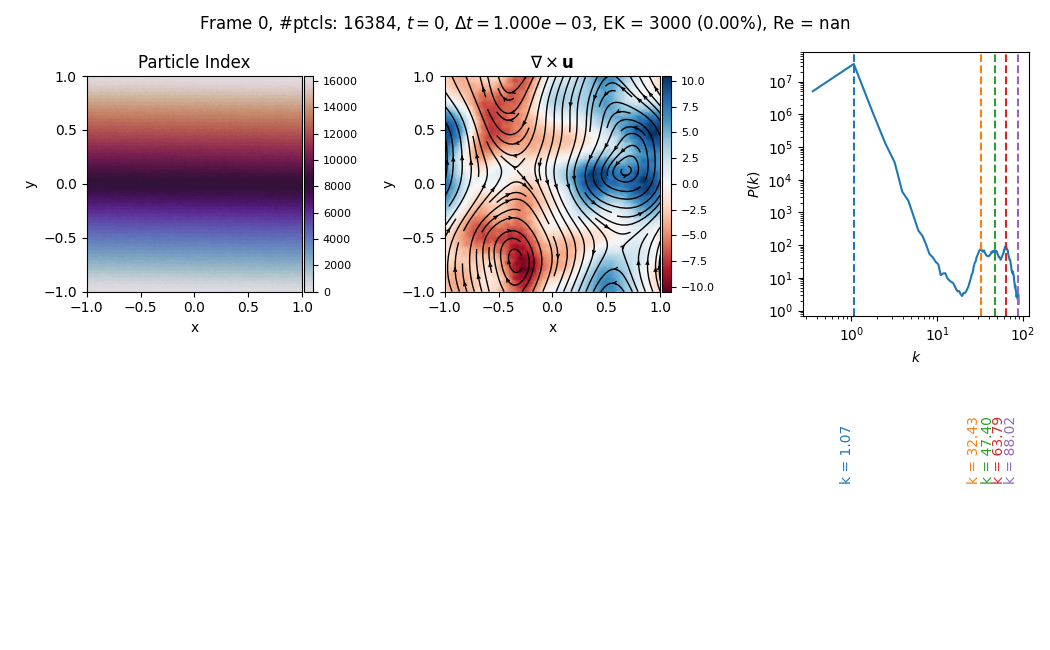

In [10]:
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid
from diffSPH.v2.sphOps import sphOperationStates

s = 1

fig, axis = plt.subplot_mosaic('''ACB''', figsize=(10.5,6.5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluid']['index']
plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'twilight', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'Particle Index')

# plotDensityIndex = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidDensities'] , cbar = True, cmap = 'Spectral_r', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= False, s = s, mapping = '.x')
# axis['B'].set_title(r'$\rho$')

curl = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'curl', gradientMode = 'difference', neighborhood = perennialState['fluid']['neighborhood'])
plotVelocityMagIndex = visualizeParticles(fig, axis['C'], config, visualizationState, curl, s = s, cmap = 'RdBu', scaling = 'sym', midPoint = 0, gridVisualization= False, mapping = '.x')
axis['C'].set_title(r'$\nabla \times \mathbf{u}$')

# plotVelocityMagIndex = visualizeParticles(fig, axis['C'], config, visualizationState, torch.norm(perennialState['fluidVelocities'], dim = 1) , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
# axis['C'].set_title(r'$|\mathbf{u}|$')

grid_ux = mapToGrid(visualizationState, perennialState['fluid']['velocities'][:,0])
grid_uy = mapToGrid(visualizationState, perennialState['fluid']['velocities'][:,1])
X = visualizationState['X']
Y = visualizationState['Y']

stream = axis['C'].streamplot(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), grid_ux.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), grid_uy.reshape(visualizationState['nGrid'], visualizationState['nGrid']).detach().cpu().numpy(), color='k', linewidth=1, density=1, arrowstyle='->', arrowsize=0.5)

data = torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)
visualizationState, physical_freqs_xx, physical_freqs_yy, fft_mag, kvals, Abins, peaks = computePSD(perennialState, data, config, nGrid = 255)

# plotVelMagIndex = visualizeParticles(fig, axis['A'], config, visualizationState, data, cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True, s = s, mapping = '.x')
# plotFFT(fig, axis['B'], physical_freqs_xx, physical_freqs_yy, fft_mag)
plotPSD(fig, axis['B'], kvals, Abins, peaks = peaks)



E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()

E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

print(f'E_k0 = {E_k0:.4g}, E_k = {E_k:.4g}, rel. diff = {(E_k - E_k0)/E_k0:.2%}, Re = {Re:.4g}')

# config['timestep']['dt'] = 0.003

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState['fluid']["numParticles"]}, $t = {perennialState["time"] :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$, EK = {E_k:.4g} ({(E_k - E_k0)/E_k0:.2%}), Re = {Re:.6g}''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)

fig.tight_layout()
del visualizationState


In [14]:
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

In [15]:
from diffSPH.v2.runner import runSimulation, setupSimulation

In [17]:
# fig, axis = plt.subplots(1,2, figsize = (10,5), squeeze = False)
# axis[0,0].scatter(positions[:,0].cpu().numpy(), positions[:,1].cpu().numpy(), s = 1)
# axis[0,1].scatter((positions + dx)[:,0].cpu().numpy(), (positions + dx)[:,1].cpu().numpy(), s = 1)

# fig.tight_layout()

0.0000%|          | 0/1 [00:00<?] ?it/s

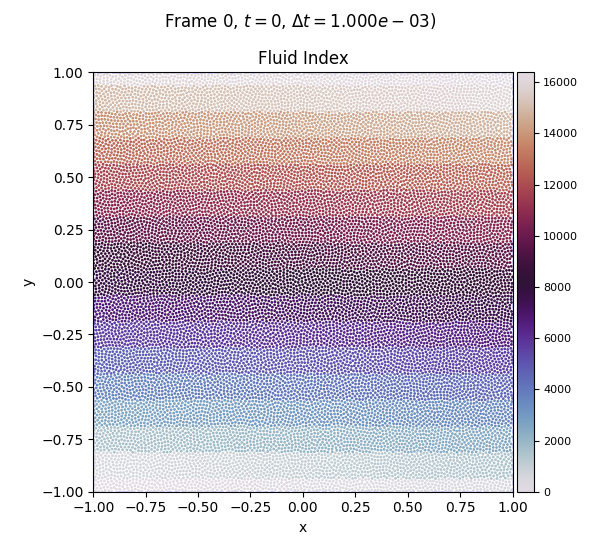

In [18]:
perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

In [19]:
from diffSPH.v2.plotting import updatePlots
updatePlots(perennialState, particleState, config, plotStates, fig, axis)

Updating plots


In [20]:
if config['plot']['fps'] > 0:
    print(f"{perennialState['time']}, {1/config['plot']['fps']}")
        # if config['plot']['fps'] > 0:
        #     if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
        #         lastUpdate = perennialState['time']
        #         updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        # else:
        #     if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        #         updatePlots(perennialState, particleState, config, plotStates, fig, axis)


0.0, 0.001


In [21]:
stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1)

Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots
Updating plots


KeyboardInterrupt: 

In [20]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

with profile(record_shapes=True, with_flops = True, profile_memory=True, with_stack=True) as prof:
    with record_function("simulation_step"):
        integrate(simulationStep, perennialState, config, None)


STAGE:2024-03-14 14:47:32 305176:305176 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-14 14:47:32 305176:305176 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-14 14:47:32 305176:305176 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [21]:
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        simulation_step         0.04%      90.000us        91.09%     228.341ms     228.341ms       0.000us         0.00%     154.598ms     154.598ms           0 

In [24]:
prof.export_chrome_trace("trace.json")

In [81]:

# See Sun et al: The delta SPH-model: Simple procedures for a further improvement of the SPH scheme
def computeTimestep2(perennialState, config):
    # if not config['timestep']['active']:
        # return config['timestep']['dt']
    # timestep condition due to viscosity
    nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
    nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
    dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
    # acoustic timestep condition

    dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
    # print(dt_v, dt_c)

    # acceleration timestep condition
    if 'fluid_dudt' in perennialState: 
        dudt = perennialState['fluid_dudt']
        max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
        dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
    else:
        dt_a = config['timestep']['maxDt'] if isinstance(config['timestep']['maxDt'], torch.Tensor) else torch.tensor(config['timestep']['maxDt'] , dtype = torch.float32, device = perennialState['fluidPositions'].device)

    dt = config['timestep']['dt']
    new_dt = dt if isinstance(dt, torch.Tensor) else torch.tensor(dt, dtype = torch.float32, device = perennialState['fluidPositions'].device)
    if config['timestep']['viscosityConstraint']:
        new_dt = dt_v
    if config['timestep']['accelerationConstraint']:
        new_dt = torch.min(new_dt, dt_a)
    if config['timestep']['acousticConstraint']:
        new_dt = torch.min(new_dt, dt_c)

    print(f'dt_v = {dt_v:.3e}, dt_c = {dt_c:.3e}, dt_a = {dt_a:.3e}, dt = {dt:.3e}, new_dt = {new_dt:.3e}')

    new_dt = torch.min(new_dt, torch.tensor(config['timestep']['maxDt'], dtype = new_dt.dtype, device = new_dt.device))
    new_dt = torch.max(new_dt, torch.tensor(config['timestep']['minDt'], dtype = new_dt.dtype, device = new_dt.device))
    return new_dt
    
computeTimestep2(perennialState, config)

dt_v = 1.907e-02, dt_c = 5.859e-04, dt_a = 1.000e-01, dt = 1.000e-03, new_dt = 5.859e-04


tensor(0.0006, device='cuda:0')

In [12]:
display(stat[-1])
print(pstate)

{'E_k': 936.30322265625,
 'maxCompression': 0.005694270133972168,
 'minCompression': 0.001956939697265625,
 'averageDensity': 1.0044219970703125,
 'averageCompression': 0.004421997070312544,
 'maxShift': 0,
 'dt_v': 0.06588076800107956,
 'dt_c': 0.0023437500931322575,
 'dt_a': 0.0022483502980321646,
 'CFLNumber': 0.64000004529953,
 'minNeighborCount': 40,
 'maxNeighborCount': 51,
 'medianNeighborCount': 45,
 'time': 1.0229999999999981,
 'timestep': 1023,
 'dt': 0.001}

{'numParticles': 16384, 'timestep': 1025, 'time': 1.024999999999998, 'dt': 0.001, 'fluidPositions': tensor([[-1.2079, -0.2349],
        [-0.9322, -0.2888],
        [-0.7614, -0.5512],
        ...,
        [ 0.6878,  1.7237],
        [ 0.6775,  1.7382],
        [ 0.7236,  1.7504]], device='cuda:0'), 'fluidAreas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'), 'fluidPressures': tensor([2075.4639, 1923.3398, 1305.1270,  ..., 1995.8008, 1924.4385,
        2030.0537], device='cuda:0'), 'fluidDivergence': tensor([-0.0389,  0.0658,  0.1100,  ...,  0.0825,  0.0118,  0.0677],
       device='cuda:0'), 'fluidMasses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'), 'fluidSupports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'), 'fluidIndex': tensor([    0,     1,     2,  ..., 16381, 16382, 16383], device='cuda:0'), 'fluidDensities': tensor([1005.1885, 1004.8083, 1003.2627,  ..., 1004.9896, 1004.811

In [58]:
E_k = stat[-1]['E_k']
E_k0 = stat[0]['E_k']


nu_total = np.log(E_k / E_k0) / (-(u_mag**2) * stat[-1]['time'] * k**2 )
print(nu_total)
Re = u_mag * 2 / nu_total
print(Re)
# print(nu_sph)

0.0019775839765502883
2022.6701103118912


ValueError: Unable to synchronously create group (name already exists)

In [98]:
f.close()


In [75]:
perennialState['time']

0.1290000000000001

In [78]:

# stats.append(frameStatistics)
# if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
    # updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    
# while(True):
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
# Particle shifting
dx, _ = solveShifting(perennialState, config)
perennialState['fluidShiftAmount'] = dx
perennialState['fluidPositions'] += dx
# Frame done, update state for next timestep
perennialState['dt'] = config['timestep']['dt']

# for i in tqdm(range(1000)):
frameStatistics = computeStatistics(perennialState, particleState, config)

<HDF5 dataset "boundaryVelocity": shape (), type "<f4">

<HDF5 dataset "fuidShiftAmount": shape (16384, 2), type "<f4">

<HDF5 dataset "boundaryDensity": shape (), type "<f4">

In [40]:
flattenedConfig = {}
for key in config:
    print(key)
    if isinstance(config[key], dict):
        for subkey in config[key]:
            print(subkey)
            val = config[key][subkey]
            if isinstance(val, torch.Tensor):
                val = val.detach().cpu().numpy()
            flattenedConfig[f'{key}_{subkey}'] = val
    else:
        flattenedConfig[key] = config[key]

domain
minExtent
maxExtent
dim
periodic
periodicity
particle
nx
dx
support
defaultVolume
defaultSupport
volume
smoothingLength
compute
device
precision
dtype
fluid
cs
rho0
mu
shifting
scheme
threshold
maxIterations
freeSurface
R
n
CFL
computeMach
solver
normalScheme
projectionScheme
surfaceScaling
summationDensity
useExtendedMask
initialization
maxSolveIter
surfaceDetection
active
timestep
dt
active
minDt
CFL
maxDt
viscosityConstraint
accelerationConstraint
acousticConstraint
sps
active
diffusion
velocityScheme
nu
delta
densityScheme
alpha
beta
pi-switch
artificial-constant
eps
nu_sph
Re
kernel
name
targetNeighbors
function
kernelScale
simulation
correctArea
supportScheme
timestamp
plot
mosaic
figSize
export
updateInterval
namingScheme
exportPath
gif
plots
gifScale
exportFPS
export
active
exportPath
namingScheme
interval
noise
n
baseFrequency
dim
octaves
persistence
lacunarity
seed
tileable
kind
gravity
active
direction
magnitude
gravityMode
potentialOrigin
integration
scheme
neighborh

In [41]:
f.attrs.update(flattenedConfig)

TypeError: Object dtype dtype('O') has no native HDF5 equivalent

In [34]:
for key in config:
    print(key)
    f.attrs.update(config[key])
# f.attrs.update(config)

domain


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [22]:
stats[0]

{'E_k': 1423.7388916015625,
 'maxCompression': 0.00021958351135253906,
 'minCompression': -0.0003139376640319824,
 'averageDensity': 1.0000007934570312,
 'averageCompression': 7.934570311896039e-07,
 'maxShift': 0,
 'dt_v': 0.06588076800107956,
 'dt_c': 0.0023437500931322575,
 'dt_a': 0.0037631948944181204,
 'CFLNumber': 0.64000004529953,
 'minNeighborCount': 45,
 'maxNeighborCount': 45,
 'medianNeighborCount': 45,
 'time': 0.001,
 'timestep': 1,
 'dt': 0.001}

Max compression: 0.5652%, min compression: 0.01229%
Average density: 1.003
Average compression: 0.3231%


Max shift: 4.042%


dt_v = 0.06588, dt_c = 0.002344, dt_a = 0.001783
CFL number: 1.92


Min neighbors: 40, max neighbors: 50
Median neighbors: 45
